In [1]:
import time
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from scipy import sparse
import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
pd.set_option('display.max_columns', 1000)
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.
C:\Users\nishant\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nishant\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nishant\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nishant\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [2]:
with open("train.json","r") as c:
    data=json.load(c)

ingr=[]
cuis=[]
for obj in data:
    ingr.extend(obj['ingredients'])
    cuis.append(obj['cuisine'])
# for obj in data:
#     ingr.extend(obj['ingredients'])
#     cuis.append(obj['cuisine'])

ingr_uniq=list(set(ingr))
cuis_uniq=list(set(cuis))
ingr_uniq.sort()

In [3]:
len(ingr_uniq)

6714

In [4]:
len(cuis_uniq)

20

In [5]:
len(ingr)

428275

### wordcloud

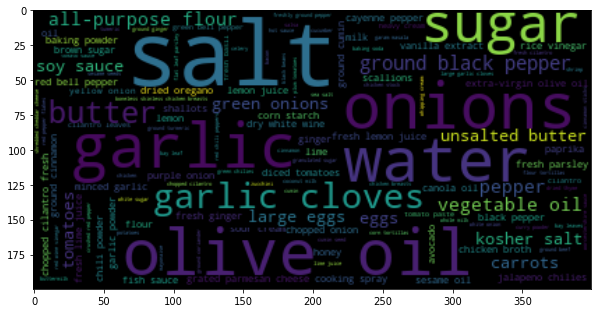

In [13]:
dd=pd.Series(ingr).value_counts().reset_index()
d = {}
for a, x in dd.values:
    d[a] = x


wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
plt.show()

### make cuisine by ingredient dataframe with frequency count 

empty_data=np.zeros((len(cuis_uniq),len(ingr_uniq)))
df=pd.DataFrame(empty_data, index=cuis_uniq, columns=ingr_uniq)

for obj in data:
    cuis_item=obj['cuisine']
    for ingredient_item in obj['ingredients']:
        df.loc[cuis_item,ingredient_item]+=1

### make recipes by ingredient dataframe 

In [6]:
start_time = time.time()
empty_data=np.zeros((len(data),len(ingr_uniq)))
df=pd.DataFrame(empty_data, index=[x['id'] for x in data], columns=ingr_uniq)

for obj in data:
    df.loc[obj['id'],obj['ingredients']]=1
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 22.09999656677246 seconds ---


In [7]:
labels=[x['cuisine'] for x in data]

### train test split

In [8]:
labels=[x['cuisine'] for x in data]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.15, random_state=42)

### logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print("train: ",clf.score(X_train,y_train))
print("test: ",clf.score(X_test,y_test))

C:\Users\nishant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nishant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


train:  0.8711509450705475
test:  0.7826378414613708


### cleaning

In [10]:
len(ingr_uniq)

6714

In [11]:
from nltk import sent_tokenize

data[285]

{'id': 45423,
 'cuisine': 'italian',
 'ingredients': ['(    oz.) tomato sauce',
  'ground veal',
  'sliced mushrooms',
  'italian seasoning mix',
  'finely chopped onion',
  'dry bread crumbs',
  'spaghetti',
  'beef',
  'diced tomatoes',
  'fresh basil leaves',
  'parmesan cheese',
  'large eggs',
  'fat skimmed chicken broth']}

In [13]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import nltk 
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('stopwords')

for obj in data:
    ing_clean=[]
    for ing in obj['ingredients']:
    #     tokens =word_tokenize(ing)

    #     print ([word for word in tokens if word.isalpha()])
        tokens = word_tokenize(ing)
        
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        
        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]

        tagged = nltk.pos_tag(words)
        words=[ele[0] for ele in tagged if ele[1] in ('NN','NNS')]

        porter = PorterStemmer()
#         stemmed = ' '.join([porter.stem(word) for word in words])

        stemmed=' '.join([ele[0] for ele in tagged if ele[1] in ('NN','NNS')])

        ing_clean.append(stemmed)
    

    obj['ingrdients_clean']=ing_clean

In [18]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import nltk 
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('stopwords')

for obj in data[:2]:
    ing_clean=[]
    for ing in obj['ingredients']:
    #     tokens =word_tokenize(ing)

    #     print ([word for word in tokens if word.isalpha()])
        tokens = word_tokenize(ing)
        
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        
        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]

        tagged = nltk.pos_tag(words)
        words=[ele[0] for ele in tagged if ele[1] in ('NN','NNS')]

        porter = PorterStemmer()
#         stemmed = ' '.join([porter.stem(word) for word in words])

        stemmed=' '.join([ele[0] for ele in tagged if ele[1] in ('NN','NNS')])

        ing_clean.append(tagged)
    
        print(ing_clean)
    obj['ingrdients_clean']=ing_clean

[[('romaine', 'NN'), ('lettuce', 'NN')]]
[[('romaine', 'NN'), ('lettuce', 'NN')], [('black', 'JJ'), ('olives', 'NNS')]]
[[('romaine', 'NN'), ('lettuce', 'NN')], [('black', 'JJ'), ('olives', 'NNS')], [('grape', 'NN'), ('tomatoes', 'NNS')]]
[[('romaine', 'NN'), ('lettuce', 'NN')], [('black', 'JJ'), ('olives', 'NNS')], [('grape', 'NN'), ('tomatoes', 'NNS')], [('garlic', 'NN')]]
[[('romaine', 'NN'), ('lettuce', 'NN')], [('black', 'JJ'), ('olives', 'NNS')], [('grape', 'NN'), ('tomatoes', 'NNS')], [('garlic', 'NN')], [('pepper', 'NN')]]
[[('romaine', 'NN'), ('lettuce', 'NN')], [('black', 'JJ'), ('olives', 'NNS')], [('grape', 'NN'), ('tomatoes', 'NNS')], [('garlic', 'NN')], [('pepper', 'NN')], [('purple', 'JJ'), ('onion', 'NN')]]
[[('romaine', 'NN'), ('lettuce', 'NN')], [('black', 'JJ'), ('olives', 'NNS')], [('grape', 'NN'), ('tomatoes', 'NNS')], [('garlic', 'NN')], [('pepper', 'NN')], [('purple', 'JJ'), ('onion', 'NN')], [('seasoning', 'VBG')]]
[[('romaine', 'NN'), ('lettuce', 'NN')], [('bla

In [14]:
ingr=[]
for obj in data:
    ingr.extend(obj['ingrdients_clean'])
ingr_uniq=list(set(ingr))

start_time = time.time()
empty_data=np.zeros((len(data),len(ingr_uniq)))
df=pd.DataFrame(empty_data, index=[x['id'] for x in data], columns=ingr_uniq)

for obj in data:
    df.loc[obj['id'],obj['ingrdients_clean']]=1
    
print("--- %s seconds ---" % (time.time() - start_time))


--- 22.845011234283447 seconds ---


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.15)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print("train: ",clf.score(X_train,y_train))
print("test: ",clf.score(X_test,y_test))

C:\Users\nishant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\nishant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


train:  0.8408613600733575
test:  0.7699011228422993


### vector

In [8]:
no_of_occurences=df.sum()

In [18]:
present_in_majority=no_of_occurences[no_of_occurences>20]

In [21]:
df1=df.loc[:,present_in_majority.index]

In [24]:
df1

1% low-fat milk  2% reduced-fat milk  Alfredo sauce  American cheese  \
10259              0.0                  0.0            0.0              0.0   
25693              0.0                  0.0            0.0              0.0   
20130              0.0                  0.0            0.0              0.0   
22213              0.0                  0.0            0.0              0.0   
13162              0.0                  0.0            0.0              0.0   
...                ...                  ...            ...              ...   
29109              0.0                  0.0            0.0              0.0   
11462              0.0                  0.0            0.0              0.0   
2238               0.0                  0.0            0.0              0.0   
41882              0.0                  0.0            0.0              0.0   
2362               0.0                  0.0            0.0              0.0   

       Anaheim chile  Belgian endive  Boston lettuce  California bay leaves  \
10259            0.0             0.0             0.0                    0.0   
25693            0.0             0.0             0.0                    0.0   
20130            0.0             0.0             0.0                    0.0   
22213            0.0             0.0             0.0                    0.0   
13162            0.0             0.0             0.0                    0.0   
...              ...             ...             ...                    ...   
29109            0.0             0.0             0.0                    0.0   
11462            0.0             0.0             0.0                    0.0   
2238             0.0             0.0             0.0                    0.0   
41882            0.0             0.0             0.0                    0.0   
2362             0.0             0.0             0.0                    0.0   

       Chinese egg noodles  Country CrockÂ® Spread  \
10259                  0.0                     0.0   
25693                  0.0                     0.0   
20130                  0.0                     0.0   
22213                  0.0                     0.0   
13162                  0.0                     0.0   
...                    ...                     ...   
29109                  0.0                     0.0   
11462                  0.0                     0.0   
2238                   0.0                     0.0   
41882                  0.0                     0.0   
2362                   0.0                     0.0   

       Dutch-processed cocoa powder  Gochujang base  Grand Marnier  \
10259                           0.0             0.0            0.0   
25693                           0.0             0.0            0.0   
20130                           0.0             0.0            0.0   
22213                           0.0             0.0            0.0   
13162                           0.0             0.0            0.0   
...                             ...             ...            ...   
29109                           0.0             0.0            0.0   
11462                           0.0             0.0            0.0   
2238                            0.0             0.0            0.0   
41882                           0.0             0.0            0.0   
2362                            0.0             0.0            0.0   

       Guinness Beer  Irish whiskey  Italian bread  Italian parsley leaves  \
10259            0.0            0.0            0.0                     0.0   
25693            0.0            0.0            0.0                     0.0   
20130            0.0            0.0            0.0                     0.0   
22213            0.0            0.0            0.0                     0.0   
13162            0.0            0.0            0.0                     0.0   
...              ...            ...            ...                     ...   
29109            0.0            0.0            0.0                     0.

In [26]:
data[]

[{'id': 10259,
  'cuisine': 'greek',
  'ingredients': ['romaine lettuce',
   'black olives',
   'grape tomatoes',
   'garlic',
   'pepper',
   'purple onion',
   'seasoning',
   'garbanzo beans',
   'feta cheese crumbles']},
 {'id': 25693,
  'cuisine': 'southern_us',
  'ingredients': ['plain flour',
   'ground pepper',
   'salt',
   'tomatoes',
   'ground black pepper',
   'thyme',
   'eggs',
   'green tomatoes',
   'yellow corn meal',
   'milk',
   'vegetable oil']},
 {'id': 20130,
  'cuisine': 'filipino',
  'ingredients': ['eggs',
   'pepper',
   'salt',
   'mayonaise',
   'cooking oil',
   'green chilies',
   'grilled chicken breasts',
   'garlic powder',
   'yellow onion',
   'soy sauce',
   'butter',
   'chicken livers']},
 {'id': 22213,
  'cuisine': 'indian',
  'ingredients': ['water', 'vegetable oil', 'wheat', 'salt']},
 {'id': 13162,
  'cuisine': 'indian',
  'ingredients': ['black pepper',
   'shallots',
   'cornflour',
   'cayenne pepper',
   'onions',
   'garlic paste',
   'm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nishant\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True